# setup environment

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [31]:
import pickle, pandas, os, json, numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# load data files

In [7]:
barense_file = '/content/gdrive/MyDrive/309_gazedata/COGNIT-D-23-00893R3_barense_data.pkl'

# load 'control_experiments' from pickle
with open(barense_file, 'rb') as f:
  barense = pickle.load(f)

In [8]:
majaj_file = '/content/gdrive/MyDrive/309_gazedata/COGNIT-D-23-00893R3_majaj_data.pkl'

# load 'control_experiments' from pickle
with open(majaj_file, 'rb') as f:
  majaj = pickle.load(f)

In [9]:
gaze_file = '/content/gdrive/MyDrive/309_gazedata/COGNIT-D-23-00893R3_gaze_data.pkl'

# load 'control_experiments' from pickle
with open(gaze_file, 'rb') as f:
  gaze = pickle.load(f)

In [6]:
salience_file = '/content/gdrive/MyDrive/309_gazedata/COGNIT-D-23-00893R3_GVBS_salience.pkl'

with open(salience_file, 'rb') as f:
  gvbs_salience = pickle.load(f)

In [10]:
control_file = '/content/gdrive/MyDrive/309_gazedata/COGNIT-D-23-00893R3_CONTROL.pkl'

# load 'control_experiments' from pickle
with open(control_file, 'rb') as f:
  control = pickle.load(f)

# set color scheme and define a helper function

In [33]:
color = { 'v4':'#c9d1d3', 'it': '#18879D', 'prc': '#4D1869'}

In [ ]:
def rescale(x, chance):

    # possible range of experimental values
    possible = 1 - chance
    # observed location within range
    actual   = np.array( x ) - chance
    # ratio of observed to possible
    adjusted = actual / possible

    return adjusted

# compare time restricted/unrestricted humans to VTC recordings/models

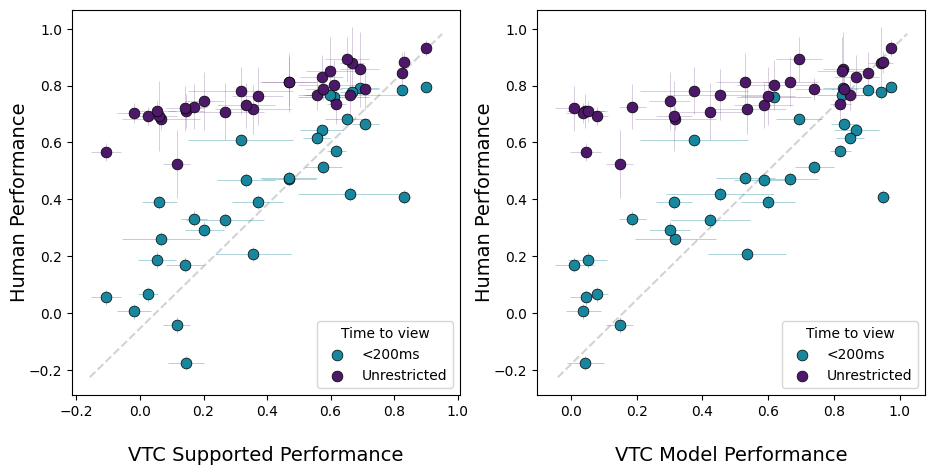

In [15]:
plt.figure(figsize=[11,5])

pointsize = 60
M =  majaj['concurrent'].groupby('typical_name')
x_it = rescale(M['it'].mean().values, 1/3)
x_cnn = rescale(M['fc6'].mean().values, 1/3)
y_con = rescale(M['human'].mean().values, 1/3)
y_mts = rescale(majaj['MTS100ms'].groupby('typical_identity')['correct'].mean(), 1/2)

for iplot in range(2):

  plt.subplot(1,2, iplot+1)
  x = [x_it, x_cnn][iplot]

  plt.scatter(x = x, y = y_mts,
              label='<200ms',
              color=color['it'], edgecolor='black', s=pointsize, linewidth=.5)

  plt.errorbar(x=x, y=y_mts, linestyle='', color=color['it'], alpha=.5,
               elinewidth=.5, zorder=-1,
               xerr=majaj['concurrent'].groupby('typical_name')['fc6'].sem().values,
               yerr=majaj['MTS100ms'].groupby('typical_identity')['correct'].sem().values)

  plt.scatter(x = x, y = y_con, label='Unrestricted',
              color=color['prc'],
              linewidth=.5, edgecolor='black', s=pointsize)


  plt.errorbar(x=x, y=y_con,
                xerr=majaj['concurrent'].groupby('typical_name')['fc6'].sem().values,
                yerr=majaj['concurrent'].groupby('typical_name')['it'].sem().values,
                linestyle='', color=color['prc'], alpha=.3, elinewidth=.5,
                zorder=-1)


  plt.ylabel('Human Performance', fontsize=14, labelpad=0)
  plt.legend(loc=4, title='Time to view')
  plt.plot([min(x)-.05, max(x)+.05], [min(y_mts)-.05, max(y_con)+.05],
          color='lightgrey', linestyle='--', zorder=-2)

  if iplot == 0:
    plt.xlabel('\nVTC Supported Performance', fontsize=14)
  else:
    plt.xlabel('\nVTC Model Performance', fontsize=14)

# lesion, time restricted, and gaze restriction data

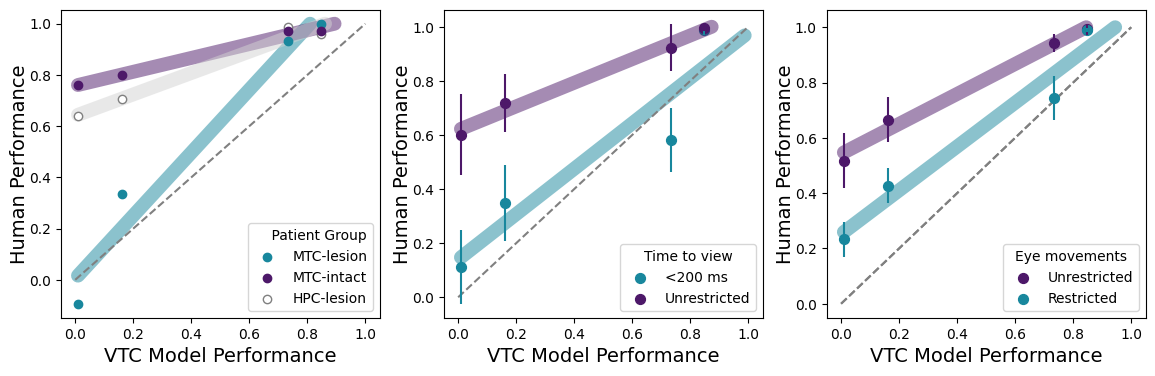

In [16]:
def plot_linefit(x, y, c, s='-', l='', a=.5):

    x = np.reshape( x, (-1, 1))
    y = np.reshape( y, (-1, 1))

    l_line = LinearRegression().fit(x, y)

    line_params = {'solid_capstyle':'round', 'linewidth':10,
                   'color': c, 'alpha':a, 'zorder':-10}

    xs = np.array([min(x),
                   min(max(y),((1 - l_line.intercept_)/l_line.coef_[0]))])

    plt.plot(xs, xs * l_line.coef_[0] + l_line.intercept_,
             **line_params, label=l, linestyle=s)


plt.figure(figsize=[14, 4])

plt.subplot(131)
xi = rescale([barense['vtc_model'][i] for i in barense['lesion']['experiment']], 1/4)
yi = rescale(barense['lesion']['prc_lesion'], 1/4)
plt.scatter(y=yi, x=xi, color=color['it'], label='MTC-lesion')
plot_linefit(xi, yi, color['it'], a=.5)

yi = rescale(barense['lesion']['prc_intact'], 1/4)
plt.scatter(y=yi, x=xi, color=color['prc'], label='MTC-intact')
plot_linefit(xi, yi, color['prc'], a=.5)

yi = rescale(barense['lesion']['hpc_lesion'], 1/4)
plt.scatter(y=yi, x=xi, color='white', edgecolor='grey',
            label='HPC-lesion', zorder=-5)

plot_linefit(xi, yi, 'lightgrey', a=.5)

plt.ylabel('Human Performance', fontsize=14, labelpad=0)
plt.legend(loc=4, title='    Patient Group')
plt.xlabel('VTC Model Performance', fontsize=14)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-10)

plt.subplot(132)

xi = rescale([barense['vtc_model'][i] for i in barense['lesion']['experiment']], 1/4)
yi = rescale(barense['mts'].groupby('trial_comparison')['correct'].mean().values, 1/2)

plt.scatter(y=yi, x=xi, color=color['it'], marker='o', label='<200 ms',
            s=50, zorder=-20)

YERRS = barense['mts'].groupby(['subject_id','trial_comparison'])[
    'correct'].mean().groupby('trial_comparison').std().values

plt.errorbar(xi, yi, yerr=YERRS, ls='', color=color['it'], alpha=1, zorder=10)

plot_linefit(xi, yi, color['it'], a=.5)

yi = rescale( barense['concurrent'].groupby('trial_comparison')[
    'correct'].mean().values, 1/3)
plt.scatter(y=yi, x=xi, color=color['prc'], marker='o',
            label='Unrestricted', s=50)

plt.errorbar(xi, yi,
             yerr=barense['concurrent'].groupby(['subject_id',
                                                 'trial_comparison'])[
                 'correct'].mean().groupby('trial_comparison').std().values,
             ls='', color=color['prc'], alpha=1, zorder=10)

plot_linefit(xi, yi, color['prc'], a=.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-10)
plt.ylabel('Human Performance', fontsize=14, labelpad=0)
plt.xlabel('VTC Model Performance', fontsize=14)
plt.legend(loc=4, title='Time to view')

plt.subplot(133)

x_adjusted = rescale([barense['vtc_model'][i] for i in list(barense['gazerestricted'])], 1/4)
y_adjusted = rescale(
    [np.mean(barense['gazerestricted'][i]) for i in list(barense['gazerestricted'])], 1/2)
y_unrestricted = rescale(
    barense['unrestricted'].groupby('condition')['correct'].mean().values, 1/2)

plt.scatter(x=x_adjusted, y=y_unrestricted,
            color=color['prc'], marker='o', label='Unrestricted', s=50)

plt.errorbar(x_adjusted, y_unrestricted,
             yerr=barense['unrestricted'].groupby(['subject','condition'])['correct'].mean().groupby('condition').std().values,
             ls='', color=color['prc'], alpha=1, zorder=10)

plot_linefit(x_adjusted, y_unrestricted, color['prc'], a=.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-10)

plt.ylabel('Human Performance', fontsize=14, labelpad=0)
plt.xlabel('VTC Model Performance', fontsize=14)
plt.legend(loc=4, title='Eye movements', framealpha=0)

plt.scatter(x=x_adjusted, y=y_adjusted, color=color['it'], marker='o', label='Restricted', s=50)

plt.errorbar(x_adjusted, y_adjusted,
             yerr=[np.std(barense['gazerestricted'][i]) for i in barense['gazerestricted']],
             ls='', color=color['it'], alpha=1, zorder=10)

plot_linefit(x_adjusted, y_adjusted, color['it'], a=.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-10)
plt.ylabel('Human Performance', fontsize=14, labelpad=0)
plt.xlabel('VTC Model Performance', fontsize=14)
plt.legend(loc=4, title='Eye movements')

# relationship between time and fixations

In [17]:
import matplotlib

def extract_and_plot_fixations_and_rts(_df, screen='sample'):

    groupby = {'sample': 'sample_image', 'match': 'image_match'}
    _time =  {'sample': 'timeonimage', 'match': 'rt'}
    fxs, rts = {}, {}

    _df = _df[_df.correct==1]

    for i_condition in _df.condition.unique():

      is_df = _df[(_df.condition==i_condition)].groupby(groupby[screen])
      i_time = is_df[_time[screen]].mean().values
      i_fixs = is_df['nfixations'].mean().values

      i_time_err = is_df[_time[screen]].sem().values
      i_fixs_err = is_df['nfixations'].sem().values

      ax.scatter(i_time[i_time<9.5] ,
                 i_fixs[i_time<9.5], color=cs[i_condition],
                 alpha=1,
                 edgecolor='black', linewidth=.5, label=i_condition, s=50)

      ax.errorbar(i_time[i_time<9.5] ,
                  i_fixs[i_time<9.5], yerr=i_fixs_err[i_time<9.5],
                  xerr=i_time_err[i_time<9.5],
                  color=cs[i_condition],
                  linewidth=1,
                  linestyle='', alpha=.4, zorder=-2)

      fxs[i_condition] =  i_fixs[i_time<9.5]
      rts[i_condition] =  i_time[i_time<9.5]

    # rectangular box plot
    bplot1 = ax_y.boxplot([fxs[i] for i in ordered],
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         showfliers=False)  # will be used to label x-ticks

    # rectangular box plot
    bplot2 = ax_x.boxplot([rts[i] for i in ordered],
                         vert=False,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         showfliers=False
                         )  # will be used to label x-ticks

    # fill with colors
    colors = [cs[i] for i in cs]
    for bplot in (bplot1, bplot2):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

    for median in bplot1['medians']:
        median.set_color('white')

    for median in bplot2['medians']:
        median.set_color('white')

    return fxs, rts

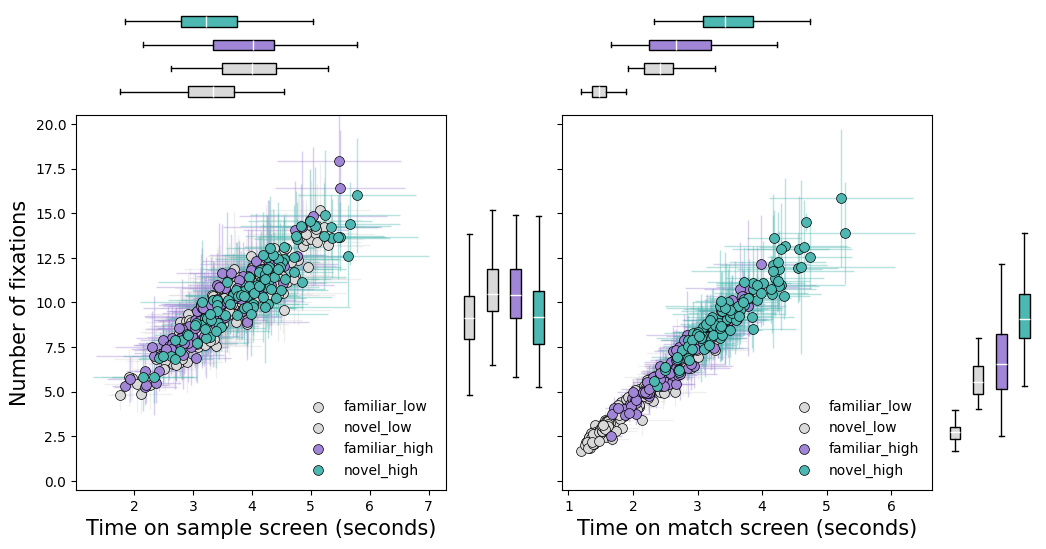

In [18]:
ordered = ['familiar_low','novel_low', 'novel_high', 'familiar_high']
cs = {'familiar_low':'#D9D9D9', 'novel_low':'#D9D9D9',
      'familiar_high':'#A185D6', 'novel_high':'#4DB8B1'}

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 4,
                      width_ratios=(4, 1, 4, 1),
                      height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_x = fig.add_subplot(gs[0, 0], sharex=ax)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax)
ax_x.axis('off')
ax_y.axis('off')
ax.set_ylim(-.5, 20.5)

sample_fxs, sample_rts = extract_and_plot_fixations_and_rts(gaze['sample'],'sample')

ax.set_xlabel('Time on sample screen (seconds)', fontsize=15)
ax.set_ylabel('Number of fixations', fontsize=15);
ax.legend(loc=4, framealpha=0)

ax = fig.add_subplot(gs[1, 2])
ax_x = fig.add_subplot(gs[0, 2], sharex=ax)
ax_y = fig.add_subplot(gs[1, 3], sharey=ax)

ordered = ['familiar_low','novel_low', 'familiar_high', 'novel_high']

ax_x.axis('off')
ax_y.axis('off')

match_fxs, match_rts = extract_and_plot_fixations_and_rts(gaze['match'], 'match')

ax_x.axis('off')
ax_y.axis('off')
ax.set_ylim(-.5, 20.5)
ax.set_yticklabels([])
ax.legend(loc=4, framealpha=0)
ax.set_xlabel('Time on match screen (seconds)', fontsize=15);

# estimate reliability of gaze patterns

In [26]:
def r(x,y):
    return np.corrcoef(x,y)[0, 1]

def show_gaze_reliability(matrices, gvbs_matrices, screen):

  plt.figure(figsize=[25, 4])

  _sames = []
  _diffs = []
  _autos = []

  s_color = 'purple'
  d_color = 'grey'
  nbins = 30

  for i_plot, i_cond in enumerate( list( matrices )):

      i_matrix = np.array( matrices[i_cond] )
      sames = np.array( [np.diag(i_matrix[i,:,:]) for i in range(i_matrix.shape[0])] ).flatten()
      diffs_lower = np.tril(i_matrix, -1).flatten()[ np.tril(i_matrix, -1).flatten() != 0]
      diffs_upper = np.triu(i_matrix, 1).flatten()[ np.triu(i_matrix, 1).flatten() != 0  ]
      diffs = np.append ( diffs_upper, diffs_lower )

      auto_mat = np.array( gvbs_matrices[i_cond] )
      auto_sames = [np.diag(auto_mat[i,:,:]) for i in range(auto_mat.shape[0])]
      auto_sames = np.array(auto_sames).flatten()
      auto_sames = auto_sames[auto_sames==auto_sames]

      plt.subplot(1,5,i_plot+1)

      bop = plt.boxplot([diffs, auto_sames, sames], patch_artist=1, showfliers=0)

      colors = ['lightgrey', 'darkgrey', 'purple']

      for patch, color in zip(bop['boxes'], colors):
        patch.set_facecolor(color)

      for median in bop['medians']:
        median.set_color('white')

      plt.xticks([ 1, 2, 3], ['between-image\ncorrelation',
                              'match to\nsalience map',
                              "split-half\nreliability'"])
      plt.title(i_cond, y=1.05);

      plt.ylabel('split-half correlation');
      plt.title('%s\n'%i_cond, fontsize=13)

      _sames.extend(sames)
      _diffs.extend(diffs)
      _autos.extend(auto_sames)

  nbins = 40
  plt.subplot(155)

  plt.hist(_sames, bins=nbins, histtype='step', color=s_color)
  plt.hist(_sames, bins=nbins, color=s_color, label='split-half reliability')

  plt.hist(_diffs, alpha=.2, bins=nbins, color=d_color, label='between images')
  plt.hist(_diffs, bins=nbins, histtype='step', color=d_color);

  plt.hist(_autos, bins=nbins, histtype='step', color='black', zorder=-10)
  plt.hist(_autos, bins=nbins, color='black', alpha=.4,
          label='fit to salience map', zorder=-10)

  plt.legend(framealpha=0, loc=[1.01,.78]) ;
  plt.xlabel('split-half correlation');
  plt.title('all conditions\n', fontsize=13)
  plt.yticks([]);

  plt.suptitle('split-half reliability of gaze behaviors on %s screen'%screen,
              y=1.1, fontsize=15)

def extract_gaze_reliability_estimates(_df, salience_maps, screen='match'):

  if screen == 'match':
    match_image = 'image_match'
    stimuli = np.sort( _df[match_image].unique() )
  elif screen == 'sample':
    stimuli = np.sort( _df.sample_image.unique() )

  conditions = ['familiar_high', 'familiar_low', 'novel_high', 'novel_low']

  matrices = {i:[] for i in conditions}
  null_mat = {i:[] for i in conditions}
  gvbs_mat = {i:[] for i in conditions}
  ikn_mat = {i:[] for i in conditions}

  for i_condition in conditions:

      # print( '\n\n\n', i_condition )

      condition_stimuli = [i for i in stimuli if i_condition in i]

      for i_screen in np.unique([i.split('_')[2] for i in condition_stimuli]):

          # print( '\n\n\n', i_screen )

          i_heatmaps = []
          j_heatmaps = []

          _trialimages = [i for i in stimuli if (i_screen in i)*(i_condition in i)]

          # print( '_trial_images', _trialimages)

          for i_image in _trialimages:

              if screen == 'match':
                # identify correct indices
                _subset = (_df[match_image].values==i_image)# * (_df.correct.values==1)
                # extract salience maps
                _heatmaps = np.array([i for i in _df[_subset]['salience_distr'].values])

              if screen == 'sample':
                # identify correct indices
                _subset = (_df.sample_image==i_image) #* (_df.correct==1)
                # extract salience maps
                _heatmaps = np.array([i for i in _df[_subset]['salience'].values])
                #print( 'HEAT', _heatmaps.shape )

              # flatten salience map
              _flatmaps = np.array([i.flatten() for i in _heatmaps ])
              # normalize map
              _flatmaps = np.array([h/h.max() for h in _flatmaps]).squeeze()

              # only select maps with the same length
              if len(_flatmaps.shape)==2:

                  # first split + average
                  i_flatmap = _flatmaps[0:len(_flatmaps)//2].mean(0)
                  # second split + average
                  j_flatmap = _flatmaps[len(_flatmaps)//2:].mean(0)
                  # add to list if not nans
                  if i_flatmap[0] == i_flatmap[0]: i_heatmaps.append(i_flatmap)
                  if j_flatmap[0] == j_flatmap[0]: j_heatmaps.append(j_flatmap)
              else:
                print('!')

          # initialize correlation matrics
          correlation_matrix = np.zeros([len(i_heatmaps),len(j_heatmaps)])
          null_matrix = np.zeros([len(i_heatmaps),len(j_heatmaps)])
          gvbs_corrmat = np.zeros([len(i_heatmaps),len(j_heatmaps)])

          # print(correlation_matrix.shape,
          #       null_matrix.shape,
          #       gvbs_corrmat.shape)
          # try:

          for i in range(len(i_heatmaps)):

              for j in range(len(j_heatmaps)):
                  #print( i, j, i_image)

                  IMGNAME = _trialimages[i]#[:-3] #+ 'png'
                  _salience = salience_maps[IMGNAME].flatten()

                  correlation_matrix[i, j] = r(i_heatmaps[i], j_heatmaps[j])
                  null_matrix[i, j] = r(i_heatmaps[i], np.random.permutation(j_heatmaps[j]))
                  correlation_matrix[i, j] = r(i_heatmaps[i], j_heatmaps[j])
                  gvbs_corrmat[i, j] = r(_salience, j_heatmaps[j])

          no_nans = (sum(np.isnan(correlation_matrix).flatten()) == 0)

          right_size = (len(correlation_matrix.flatten() )==9)

          if no_nans and right_size :

              matrices[i_condition].append(  correlation_matrix)
              null_mat[i_condition].append(  null_matrix )
              gvbs_mat[i_condition].append(  gvbs_corrmat )


          # except Exception as e: print('!!!', i_screen, n_clusters, e)

  return matrices, null_mat, gvbs_mat

In [27]:
sample_matrices, sample_null, gvbs_sample = extract_gaze_reliability_estimates(gaze['sample'], gvbs_salience, screen='sample')

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


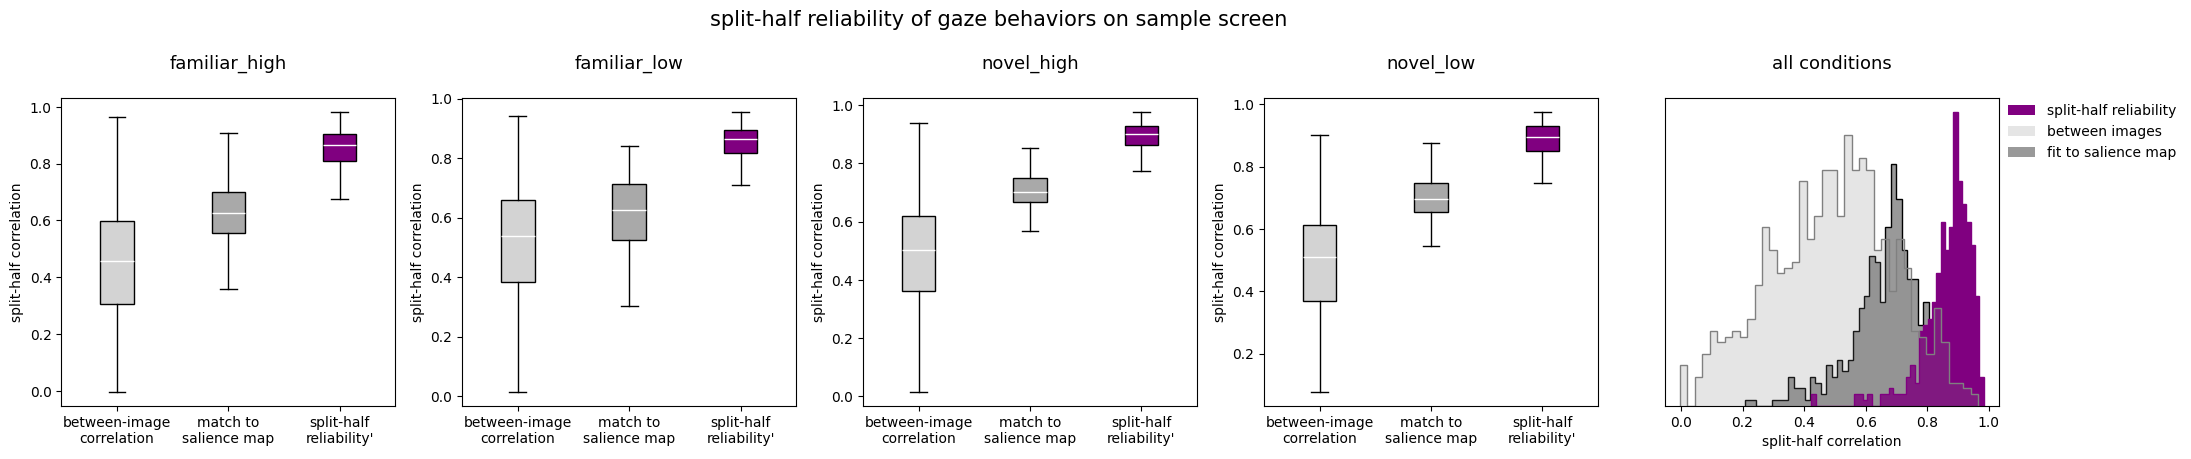

In [28]:
show_gaze_reliability(sample_matrices, gvbs_sample, screen='sample' )

# **control experiments (supplemental figures)**

# self paced match to sample behavior on barense stimuli

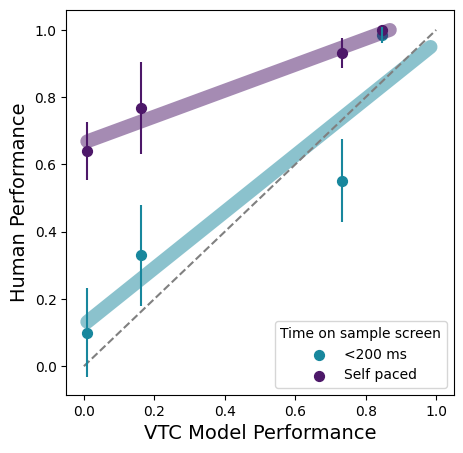

In [29]:
df_mts_subset = control['barense']['df_mts_subset']
barense_sp = control['barense']['barense_sp']

plt.figure(figsize=[5, 5])


xi = rescale( [barense['vtc_model'][i] for i in barense['lesion']['experiment']], 1/4)
yi = rescale(
      df_mts_subset.groupby('trial_comparison')['correct'].mean().values, 1/2)

plt.scatter(y = yi,
            x = xi,
            color=color['it'],
            marker='o',
            label='<200 ms',
            s=50,
            zorder=-20
            )

plt.errorbar(xi,
             yi,
             yerr=df_mts_subset.groupby(['subject_id','trial_comparison'], as_index=False)['correct'].mean().groupby('trial_comparison')['correct'].std().values,
             ls='',
             color=color['it'],
             alpha=1,
             zorder=10, )

plot_linefit(xi, yi, color['it'], a=.5)

yi = rescale(
    barense_sp.groupby('trial_comparison')['correct'].mean().values, 1/3)

plt.scatter(y = yi, x = xi,
            color=color['prc'], marker='o', label='Self paced', s=50,)

plt.errorbar(xi, yi,
             yerr=barense_sp.groupby(['subject_id','trial_comparison'], as_index=0)['correct'].mean().groupby('trial_comparison')['correct'].std().values,
             ls='', color=color['prc'], alpha=1, zorder=10, )

plot_linefit(xi, yi, color['prc'], a=.5)

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-10,)
plt.ylabel('Human Performance', fontsize=14)
plt.xlabel('VTC Model Performance', fontsize=14)
plt.legend(loc=4, title='Time on sample screen')

# self paced match to sample behavior on majaj stimuli

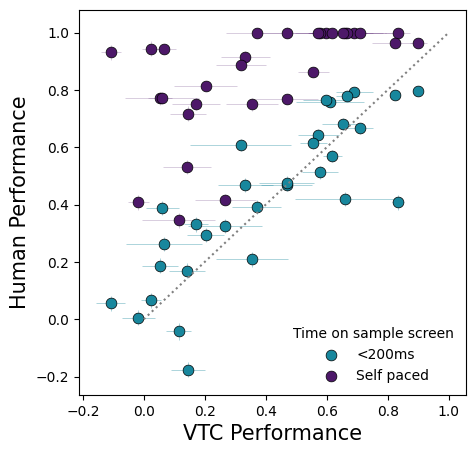

In [30]:
plt.figure(figsize=[5, 5])

psize = 60
Mgroups =  majaj['concurrent'].groupby('typical_name')
x_it = rescale(Mgroups['it'].mean().values, 1/3)
x_cnn= rescale( Mgroups['fc6'].mean().values, 1/3)
y_con =  rescale( Mgroups['human'].mean().values, 1/3)
y_mts = rescale(majaj['MTS100ms'].groupby('typical_identity')['correct'].mean(), 1/2)

colors = ['#553772', '#8f3b76', '#c7417b', '#f5487f'][-1::-1] # '#1f306e',

shared = control['majaj']['mts_hvm_selfp_indices_subset'].typical_identity.unique()

_Y =  control['majaj']['mts_hvm_selfp_indices_subset']
y1 = [_Y[_Y.typical_identity==i]['correct'].mean() for i in shared]

x = x_it
plt.scatter(x = x, y = y_mts, label='<200ms',
            color=color['it'], edgecolor='black', s=psize, linewidth=.5)

plt.errorbar(x=x, y=y_mts, xerr=Mgroups['fc6'].sem().values,
             yerr=majaj['MTS100ms'].groupby('typical_identity')['correct'].sem().values,
             linestyle='',color=color['it'],alpha=.5,elinewidth=.5,zorder=-1,)

x0 = [majaj['concurrent'][majaj['concurrent'].typical_name==i]['it'].mean() for i in shared]

plt.scatter(x = rescale(x0, 1/3),
            y = rescale(y1, 1/2),
            color=color['prc'],
            linewidth=.5, edgecolor='black', s=psize,
            label='Self paced')

plt.errorbar(
    x=rescale(x0, 1/3), y=rescale(y1, 1/2),
    xerr=[majaj['concurrent'][majaj['concurrent'].typical_name==i]['it'].sem() for i in shared],
    yerr=[majaj['MTSselfpaced'][majaj['MTSselfpaced'].typical_identity==i]['correct'].sem() for i in shared],
    linestyle='', color=color['prc'], alpha=.3, elinewidth=.5, zorder=-1,)

plt.plot([0, 1],[0, 1], linestyle=':', color='grey')
plt.legend(title='Time on sample screen', loc=4, framealpha=0)
plt.xlabel('VTC Performance', fontsize=15)
plt.ylabel('Human Performance', fontsize=15);